# Counting nuclei in tiles

In this notebook we will process a big dataset that has been saved in zarr format to count cells in individual tiles. For every tile, we will write a pixel in an output image. Hence, we are producing a cell-count image that is smaller than the original image by a factor that corresponds to the tile size.

**Please note:** This notebook will stress-test your graphics card. Before running it, save all files. It is possible that the graphics cards driver crashes while executing this. If you feel unsure, consider running this notebook on the cluster only.

In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread
import pyclesperanto as cle
from stackview import imshow
import stackview

In [2]:
cle.select_device("TX")

(OpenCL) NVIDIA GeForce RTX 4070 Laptop GPU (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              560.94
	Device Type:                 GPU
	Compute Units:               36
	Global Memory Size:          8187 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         2046 MB
	Max Clock Frequency:         1230 MHz
	Image Support:               Yes

For demonstration purposes, we use a dataset that is provided by Theresa Suckert, OncoRay, University Hospital Carl Gustav Carus, TU Dresden. The dataset is licensed [License: CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). We are using a cropped version here that was resaved a 8-bit image to be able to provide it with the notebook. You find the full size 16-bit image in CZI file format [online](https://zenodo.org/record/4276076#.YX1F-55BxaQ).

## Loading the zarr-backed image
Dask brings built-in support for the zarr file format. We can create dask arrays directly from a zarr file.

In [3]:
zarr_filename = 'data/P1_H_C3H_M004_17-cropped.zarr'

zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(2000, 5000), dtype=uint8, chunksize=(500, 500), chunktype=numpy.ndarray>

We can apply image processing to this tiled dataset directly.

## Counting nuclei
For counting the nuclei, we setup a simple image processing workflow that applies Voronoi-Otsu-Labeling to the dataset. Afterwards, we count the segmented objects. As nuclei might be counted twice which touch the tile border, we have to correct the count for every tile. Technically, we could remove the objects which touch one of the vertical or horizontal tile borders. However, there is a simpler way for correcting for this error: We count the number of nuclei after segmentation. Then, we remove all nuclei which touch any image border and count the remaining nuclei again. We can then assume that half of the removed nuclei should be counted. Hence, we add the two counts, before and after edge-removal, and compute the average of these two measurements. Especially on large tiles with many nuclei, the remaining error should be negligible. It is not recommended to apply such an estimating cell counting method when each tile contains only few nuclei.

In [4]:
def count_nuclei(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    print("Processing image of size", image.shape)
    
    # Count nuclei including those which touch the image border
    labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5)
    label_intensity_map = cle.mean_intensity_map(image, labels)
    
    nuclei_count = label_intensity_map.max()
    
    # Count nuclei including those which touch the image border
    labels_without_borders = cle.exclude_labels_on_edges(label_intensity_map)
    nuclei_count_excluding_borders = labels_without_borders.max()
    
    # Both nuclei-count including and excluding nuclei at image borders 
    # are no good approximation. We should exclude the nuclei only on 
    # half of the borders to get a good estimate.
    # Alternatively, we just take the average of both counts.
    result = np.asarray([[(nuclei_count + nuclei_count_excluding_borders) / 2]])
    
    #print(result.shape)
    
    return result

Before we can start the computation, we need to deactivate asynchronous execution of operations in pyclesperanto. [See also related issue](https://github.com/clEsperanto/pyclesperanto_prototype/issues/163).

In [5]:
#cle.wait_for_kernel_finish(True)

This time, we do not use tile overlap, because we are not measuring properties of the nuclei and thus, don't need a prefect segmentation of them.

In [6]:
tile_map = da.map_blocks(count_nuclei, zarr_image)

tile_map

Processing image of size (0, 0)
Processing image of size (1, 1)
Processing image of size (0, 0)


dask.array<count_nuclei, shape=(2000, 5000), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>

As the result image is much smaller then the original, we can compute the whole result map.

In [7]:
result = tile_map.compute()

Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of size (500, 500)
Processing image of sizeProc

In [8]:
result.shape

(4, 10)

Again, as the result map is small, we can just visualize it.

[[2.91666687e-01 1.17647067e-01 1.08108103e-01 1.20689653e-01
  3.45280895e+01 1.05611485e+02 8.70858231e+01 7.66541367e+01
  1.01995834e+02 1.07682880e+02]
 [1.02152382e+02 7.84645844e+01 8.21951866e+01 7.08040543e+01
  7.53214302e+01 1.08524876e+02 7.55409355e+01 9.41184196e+01
  1.07633331e+02 9.24234238e+01]
 [9.83196030e+01 6.52899170e+01 7.64819832e+01 8.86875000e+01
  9.03942299e+01 1.02937328e+02 1.03779854e+02 1.06735294e+02
  1.08961906e+02 1.24826973e+02]
 [1.09819298e+02 1.06567902e+02 1.13835587e+02 1.03714287e+02
  1.07339695e+02 1.23065216e+02 1.20427086e+02 1.28658340e+02
  1.31859375e+02 1.35540443e+02]]
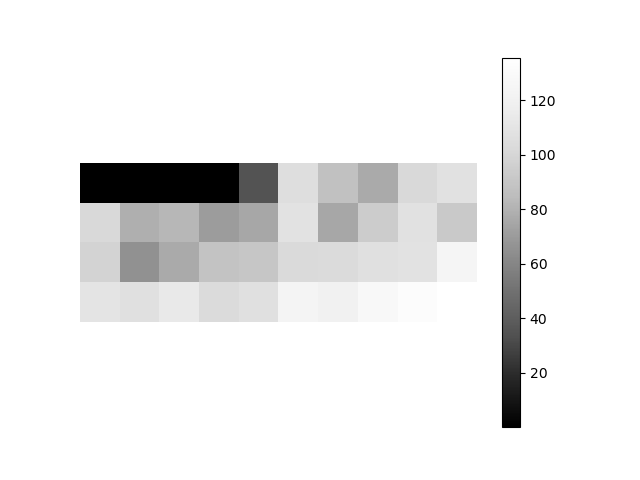
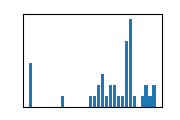

In [9]:
stackview.insight(result)

With a quick visual check in the original image, we can see that indeed in the bottom left corner of the image, there are more cells than in the top right.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
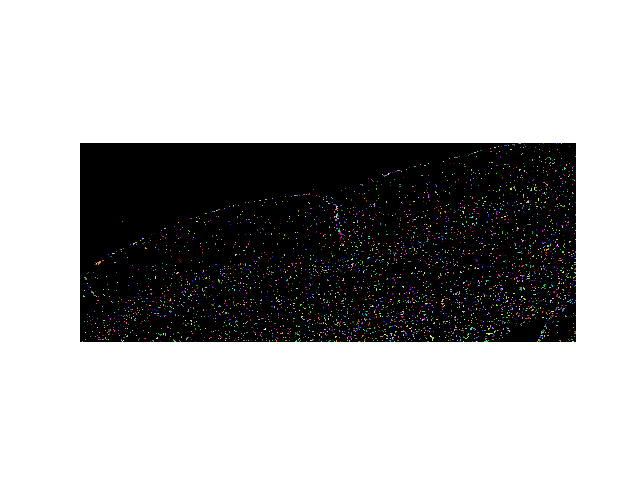

In [10]:
image = zarr_image.compute() # this would not work if the image was larger than computer memory.

stackview.insight(cle.voronoi_otsu_labeling(image, spot_sigma=3.5))

## Exercise
Compare the nuclei count results of both methods.